In [1]:
from pathlib import Path
import numpy as np
import transformers
import zarr
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchaudio
import lightning as L
from lightning.pytorch import loggers
import torch

torch.set_float32_matmul_precision("medium")
L.seed_everything(seed=1337, workers=True)

Seed set to 1337


1337

In [2]:
root_path = Path("/home/john/mp/voice-finder")

train_dataset_path = root_path / "data" / "preprocessed" / "train_full_v5.zarr"
dev_dataset_path = root_path / "data" / "preprocessed" / "dev_full_v5.zarr"

In [3]:
class VoicePairDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset_path: Path,
        frac_same_speaker: float = 0.25,
        sequence_length: int = 500,
    ):
        super().__init__()

        self._dataset_path = dataset_path
        self._dataset = zarr.open(dataset_path)

        self._frac_same_speaker = frac_same_speaker

        # sequence_length * <model-stride> / 1000 = seconds
        self._sequence_length = sequence_length

        # Precount all the samples for each client
        self._client_samples = {}
        self.prepare_client_samples()

    def prepare_client_samples(self):
        for client_idx in np.unique(self._dataset["client_index"][:]):
            self._client_samples[client_idx.item()] = np.where(
                self._dataset["client_index"][:] == client_idx
            )[0]
        self._client_indices = np.array(list(self._client_samples.keys()))

    def __len__(self):
        return self._dataset["features"].shape[0]

    def __getitem__(self, sample_1_idx: int):

        sample_1_client_idx = self._dataset["client_index"][sample_1_idx].item()

        if np.random.random() < self._frac_same_speaker:
            sample_2_idx = np.random.choice(
                self._client_samples[sample_1_client_idx][
                    self._client_samples[sample_1_client_idx] != sample_1_idx
                ]
            )
            # sample_2_idx = np.random.choice(self._client_samples[sample_1_client_idx])
            sample_2_client_idx = sample_1_client_idx
        else:
            """
            sample_2_client_idx = np.random.choice(
                [x for x in self._client_samples.keys() if x != sample_1_client_idx]
            )
            """
            sample_2_client_idx = np.random.choice(
                self._client_indices[self._client_indices != sample_1_client_idx]
            )

            sample_2_idx = np.random.choice(self._client_samples[sample_2_client_idx])

        sample_1_features = torch.from_numpy(
            self._dataset["features"][
                sample_1_idx, :, 0 : self._sequence_length
            ].astype(np.float32)
        )
        sample_2_features = torch.from_numpy(
            self._dataset["features"][
                sample_2_idx, :, 0 : self._sequence_length
            ].astype(np.float32)
        )

        sample_1_attention_mask = torch.from_numpy(
            self._dataset["attention_mask"][
                sample_1_idx, 0 : self._sequence_length
            ].astype(np.float32)
        )
        sample_2_attention_mask = torch.from_numpy(
            self._dataset["attention_mask"][
                sample_2_idx, 0 : self._sequence_length
            ].astype(np.float32)
        )

        return {
            "sample_1_features": sample_1_features,
            "sample_2_features": sample_2_features,
            "sample_1_attention_mask": sample_1_attention_mask,
            "sample_2_attention_mask": sample_2_attention_mask,
            "sample_1_client_idx": sample_1_client_idx,
            "sample_2_client_idx": sample_2_client_idx,
            "same_client": (sample_1_client_idx == sample_2_client_idx),
        }

In [4]:
sequence_length = 1000
train_dataset = VoicePairDataset(
    train_dataset_path, frac_same_speaker=0.25, sequence_length=sequence_length
)

dev_dataset = VoicePairDataset(
    dev_dataset_path, frac_same_speaker=0.25, sequence_length=sequence_length
)


train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    num_workers=8,
    pin_memory=True,
    shuffle=True,
    prefetch_factor=4,
    persistent_workers=True,
    # ccollate_fn=collate_fn,
)

dev_dataloader = torch.utils.data.DataLoader(
    dev_dataset,
    batch_size=128,
    num_workers=8,
    pin_memory=True,
    shuffle=False,
    prefetch_factor=4,
    persistent_workers=True,
    # ccollate_fn=collate_fn,
)

In [82]:
def contrastive_loss(distances, labels, margin: float = 1.0):

    return labels * distances.pow(2) + (1 - labels) * torch.nn.functional.relu(
        margin - distances
    ).pow(2)


def get_model(model_name, sequence_length):

    model_state_dict = transformers.WhisperModel.from_pretrained(
        model_name
    ).state_dict()

    # Shorten embedding length to desired sequence_length
    model_state_dict["encoder.embed_positions.weight"] = model_state_dict[
        "encoder.embed_positions.weight"
    ][0 : sequence_length // 2, :]

    model_config = transformers.WhisperConfig.from_pretrained(
        model_name, max_source_positions=sequence_length // 2
    )

    model = transformers.WhisperModel(model_config)

    model.load_state_dict(model_state_dict)

    return model.encoder


class VoiceEmbedderModule(L.LightningModule):
    def __init__(self, sequence_length: int, lr: float):
        super().__init__()

        self.model = get_model("openai/whisper-base", sequence_length=sequence_length)

        self.projector_head = torch.nn.Sequential(
            torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 256)
        )

        self._lr = lr

        self.save_hyperparameters()

        window_size = 25
        self.register_buffer(
            "_energy_mask_kernel",
            (
                torch.ones(
                    1,
                    1,
                    window_size,
                )
                / window_size
            ),
        )

    def calculate_energy_mask(self, features, threshold: float = 0.1):
        energy = (
            (torch.gradient(features.norm(dim=1))[0].abs() > threshold)
            .float()
            .unsqueeze(1)
        )

        energy = torch.nn.functional.conv1d(
            energy,
            self._energy_mask_kernel,
            padding=self._energy_mask_kernel.shape[-1] // 2,
        )

        energy[energy > 0.0] = 1.0

        energy = torch.nn.functional.interpolate(
            energy, size=energy.shape[-1] // 2, mode="linear"
        )

        return energy.bool().reshape(energy.shape[0], energy.shape[2], 1)

    def mean_pool_with_energy_mask(self, hidden_state, energy_mask):
        masked_hidden_state = hidden_state * energy_mask

        mean_pooled_hidden_state = masked_hidden_state.sum(dim=1) / energy_mask.sum(
            dim=1, keepdim=True
        ).clamp(min=1e-8)

        return mean_pooled_hidden_state

    def forward(self, **inputs):

        return_energy_mask = inputs.pop("return_energy_mask", False)

        encoder_out = self.model(**inputs)

        use_energy_mask = False
        if use_energy_mask:
            energy_mask = self.calculate_energy_mask(inputs["input_features"])
            hidden_state = self.mean_pool_with_energy_mask(
                encoder_out.last_hidden_state, energy_mask
            )
        else:
            hidden_state = encoder_out.last_hidden_state.mean(dim=1)

        embedding = self.projector_head(hidden_state)
        # embedding = mean_pooled_hidden_state

        if return_energy_mask:
            return embedding, energy_mask
        else:
            return embedding

    def training_step(self, batch, batch_idx):

        sample_1_embedding = self(
            input_features=batch["sample_1_features"],
            attention_mask=batch["sample_1_attention_mask"],
            return_energy_mask=False,
        )

        sample_2_embedding = self(
            input_features=batch["sample_2_features"],
            attention_mask=batch["sample_2_attention_mask"],
            return_energy_mask=False,
        )

        # Compute the distance between the two samples
        distance = torch.nn.functional.pairwise_distance(
            sample_1_embedding, sample_2_embedding
        )

        loss = contrastive_loss(distance, batch["same_client"].int(), margin=1.0)

        loss = loss.mean()

        avg_distance = distance.mean()

        avg_same_distance = distance[batch["same_client"]].mean()
        avg_different_distance = distance[~batch["same_client"]].mean()

        self.log("train/loss", loss, on_epoch=True)
        self.log("train/avg_distance", avg_distance, on_epoch=True)
        self.log("train/avg_same_distance", avg_same_distance, on_epoch=True)
        self.log("train/avg_different_distance", avg_different_distance, on_epoch=True)
        """
        self.log(
            "train/avg_energy_mask_activation",
            (sample_1_energy_mask.float().mean() + sample_2_energy_mask.float().mean())
            / 2,
        )
        """

        sample_1_embedding_length = sample_1_embedding.norm(dim=1).mean()
        sample_2_embedding_length = sample_2_embedding.norm(dim=1).mean()

        self.log(
            f"train/avg_embedding_length",
            (sample_1_embedding_length + sample_2_embedding_length) / 2,
            on_epoch=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):

        sample_1_embedding = self(
            input_features=batch["sample_1_features"],
            attention_mask=batch["sample_1_attention_mask"],
            return_energy_mask=False,
        )

        sample_2_embedding = self(
            input_features=batch["sample_2_features"],
            attention_mask=batch["sample_2_attention_mask"],
            return_energy_mask=False,
        )

        # Compute the distance between the two samples
        distance = torch.nn.functional.pairwise_distance(
            sample_1_embedding, sample_2_embedding
        )

        loss = contrastive_loss(distance, batch["same_client"].int(), margin=1.0)

        loss = loss.mean()

        avg_distance = distance.mean()

        avg_same_distance = distance[batch["same_client"]].mean()
        avg_different_distance = distance[~batch["same_client"]].mean()

        self.log("val/loss", loss, on_epoch=True)
        self.log("val/avg_distance", avg_distance, on_epoch=True)
        self.log("val/avg_same_distance", avg_same_distance, on_epoch=True)
        self.log("val/avg_different_distance", avg_different_distance, on_epoch=True)
        """
        self.log(
            "train/avg_energy_mask_activation",
            (sample_1_energy_mask.float().mean() + sample_2_energy_mask.float().mean())
            / 2,
        )
        """

        sample_1_embedding_length = sample_1_embedding.norm(dim=1).mean()
        sample_2_embedding_length = sample_2_embedding.norm(dim=1).mean()

        self.log(
            f"val/avg_embedding_length",
            (sample_1_embedding_length + sample_2_embedding_length) / 2,
            on_epoch=True,
        )

        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self._lr)


lr = 1e-5
module = VoiceEmbedderModule(lr=lr, sequence_length=sequence_length).train()

In [6]:
logger = loggers.TensorBoardLogger("voice-finder-experiment")

trainer = L.Trainer(
    max_steps=30000,
    log_every_n_steps=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=logger,
    accumulate_grad_batches=4,
    precision="16-mixed",
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_dataloaders=train_dataloader, val_dataloaders=dev_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | model          | WhisperEncoder | 20.1 M | train
1 | projector_head | Sequential     | 393 K  | train
----------------------------------------------------------
20.2 M    Trainable params
256 K     Non-trainable params
20.5 M    Total params
81.890    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

In [59]:
module_loaded = VoiceEmbedderModule.load_from_checkpoint(
    "/home/john/mp/voice-finder/voice-finder-experiment/lightning_logs/version_41/checkpoints/epoch=50-step=30000.ckpt"
)

In [83]:
module = module.cuda().eval()

In [84]:
all_embeddings = []
client_indices = []
for batch in tqdm(dev_dataloader, total=len(dev_dataloader)):
    with torch.no_grad():
        embeddings = module(
            attention_mask=batch["sample_1_attention_mask"].cuda(),
            input_features=batch["sample_1_features"].cuda(),
        )
        all_embeddings.append(embeddings)
        client_indices.append(batch["sample_1_client_idx"].cuda())
embs = torch.concatenate(all_embeddings)
indices = torch.concatenate(client_indices)

100%|█████████████████████████████████████████████████████████████████████| 49/49 [00:10<00:00,  4.55it/s]


In [85]:
# dists = torch.nn.functional.pairwise_distance(embs, embs, p=2)
dists = torch.cdist(embs, embs)
same_client = indices.unsqueeze(0) == indices.unsqueeze(0).T
avg_same_dist = dists[same_client & ~torch.eye(dists.shape[0]).bool().cuda()].mean()
avg_different_dist = dists[
    ~same_client & ~torch.eye(dists.shape[0]).bool().cuda()
].mean()

print(f"Average same distance:\t{avg_same_dist.item()}")
print(f"Average different distance:\t{avg_different_dist.item()}")

Average same distance:	0.7610713839530945
Average different distance:	0.8938103318214417


In [86]:
# Topk retrieval

sim = -dists.clone()

sim[torch.eye(sim.shape[0]).bool().cuda()] = -float("inf")

topk = torch.topk(sim, k=5, dim=1)
topk_indices = topk.indices
matches = (indices[topk_indices] == indices.unsqueeze(1)).any(dim=1)

In [87]:
matches.float().mean()

tensor(0.0978, device='cuda:0')

In [ ]:
features = batch["sample_1_features"]

window_size = 25
kernel = torch.ones(1, 1, window_size) / window_size

energy = (torch.gradient(features.norm(dim=1))[0].abs() > 0.1).float().unsqueeze(1)

energy2 = torch.nn.functional.conv1d(energy, kernel, padding=window_size // 2)

energy2[energy2 > 0.0] = 1.0

In [ ]:
energy2.shape

torch.Size([128, 1, 1000])

torch.Size([1000])


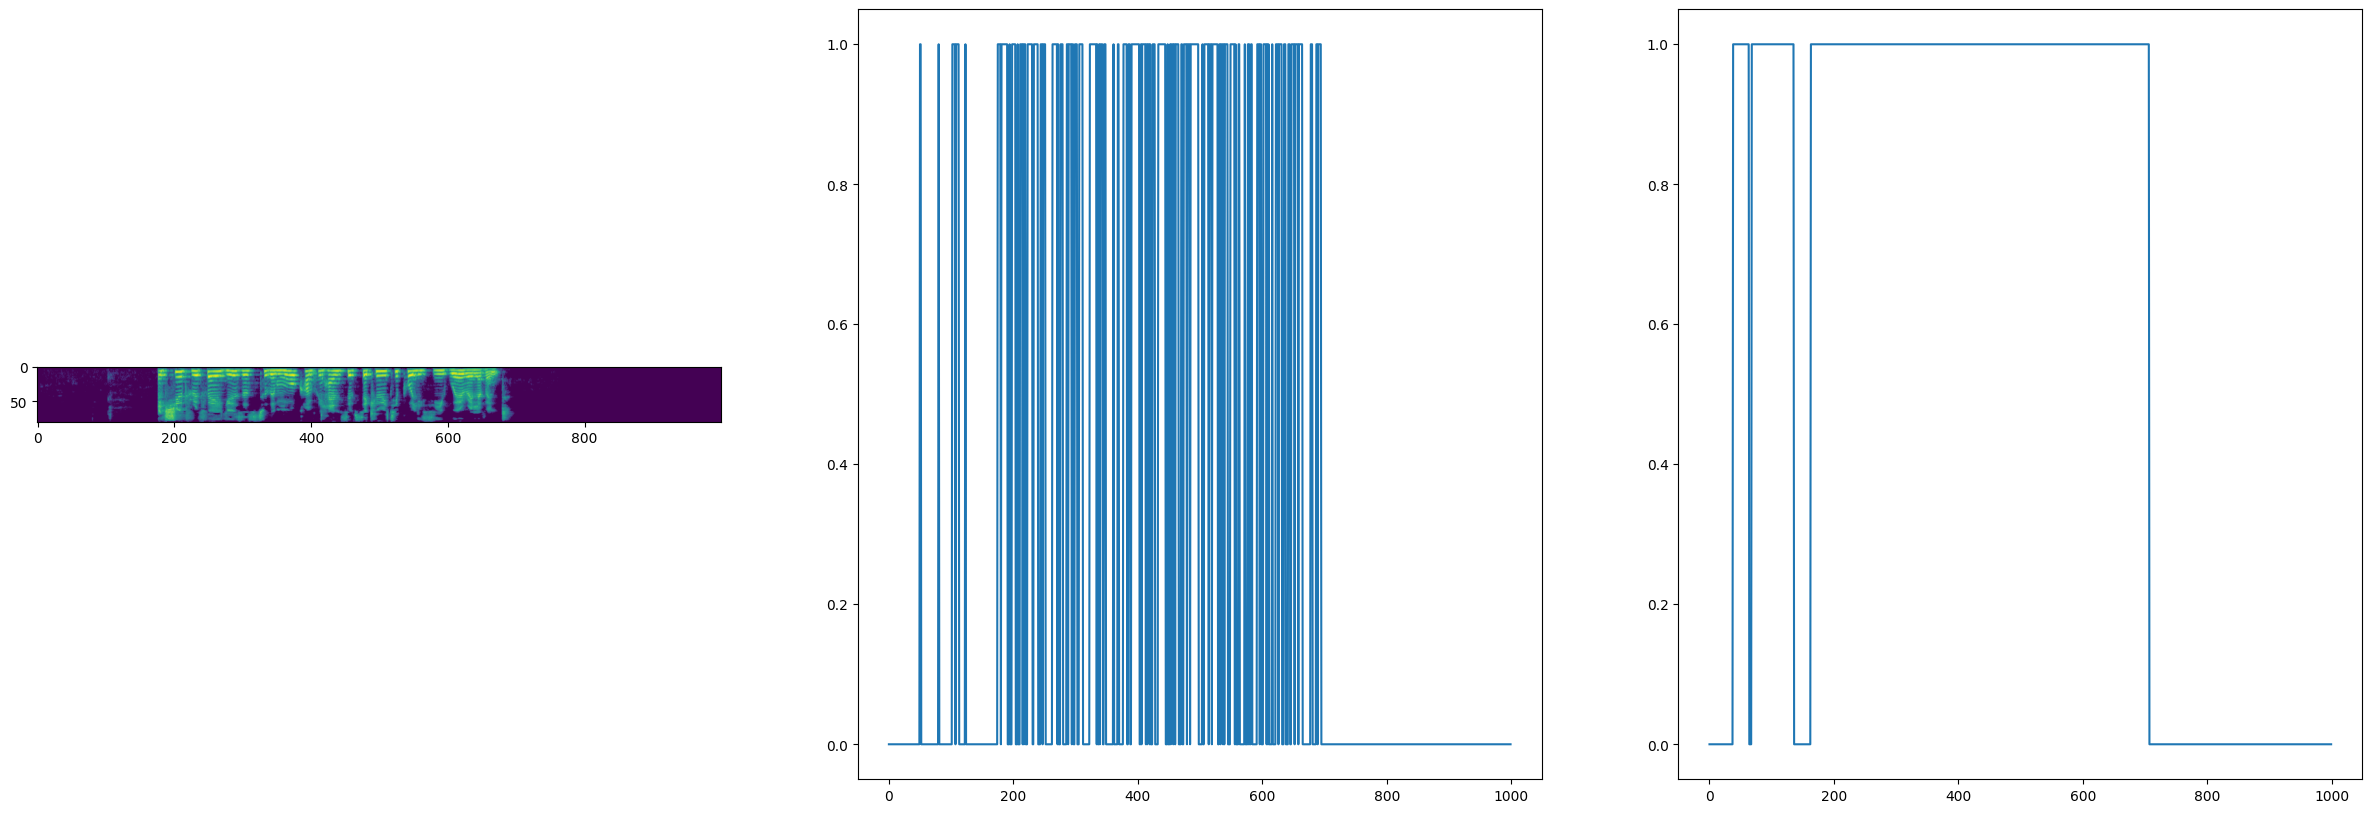

In [ ]:
sample_index = 6

features = batch["sample_1_features"][sample_index, :]

window_size = 25
kernel = torch.ones(1, 1, window_size) / window_size

energy = torch.gradient(features.norm(dim=0))[0].abs() > 0.1

energy2 = torch.nn.functional.conv1d(
    energy.unsqueeze(0).float(), kernel, padding=window_size // 2
)[0, :]

energy2[energy2 > 0.0] = 1.0

print(energy2.shape)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(features)
ax[1].plot(energy)
ax[2].plot(energy2)

In [ ]:
plt.plot(torch.gradient(energy)[0])

RuntimeError: Subtraction, the `-` operator, with two bool tensors is not supported. Use the `^` or `logical_xor()` operator instead.

In [ ]:
energy_mask = module.calculate_energy_mask(batch["sample_1_features"])

torch.Size([128, 1, 1000])


In [ ]:
module.cuda()

VoiceEmbedderModule(
  (model): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)


In [ ]:
out = module.model(
    input_features=batch["sample_1_features"].cuda(),
    attention_mask=batch["sample_1_attention_mask"].cuda(),
)
out.last_hidden_state.max(dim=1).values.shape

torch.Size([128, 512])

In [ ]:
out.last_hidden_state.shape

torch.Size([128, 500, 512])

In [ ]:
energy_mask.reshape(128, 500, 1).shape

torch.Size([128, 500, 1])

In [ ]:
masked_embedding = out.last_hidden_state * energy_mask.squeeze(1).unsqueeze(2).cuda()

In [ ]:
aaa = (
    masked_embedding.sum(dim=1) / energy_mask.squeeze(1).sum(dim=1, keepdim=True).cuda()
)

In [ ]:
aaa.shape

torch.Size([128, 512])

In [ ]:
out.last_hidden_state[energy_mask, :].shape

IndexError: too many indices for tensor of dimension 3

In [ ]:
torch.nn.functional.interpolate(
    energy2.unsqueeze(0).unsqueeze(0), size=500, mode="linear"
)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.00

In [ ]:
out.last_hidden_state.shape

torch.Size([128, 500, 512])

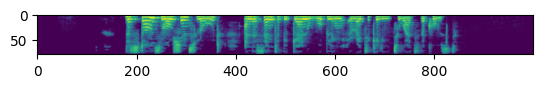

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(batch["sample_1_attention_mask"][0, :])
plt.imshow(batch["sample_1_features"][0, :])

In [ ]:
torch.save(trainer.model.state_dict(), "train_full_v1_2.pth")

In [ ]:
model_test_state_dict = transformers.WhisperModel.from_pretrained(
    "openai/whisper-base"
).state_dict()

model_test_state_dict["encoder.embed_positions.weight"] = model_test_state_dict[
    "encoder.embed_positions.weight"
][:500, :]

model_test_config = transformers.WhisperConfig.from_pretrained(
    "openai/whisper-base", max_source_positions=500
)
model_test = transformers.WhisperModel(model_test_config)

model_test.load_state_dict(model_test_state_dict)

model_test = model_test.encoder

In [ ]:
batch = next(iter(dataloader))

In [ ]:
batch["sample_1_attention_mask"] = batch["sample_1_attention_mask"][:, 0:1000]
batch["sample_1_features"] = batch["sample_1_features"][:, :, 0:1000]

In [ ]:
output = model_test(
    input_features=batch["sample_1_features"],
    attention_mask=batch["sample_1_attention_mask"],
)

In [ ]:
output.last_hidden_state.shape

torch.Size([48, 500, 512])